In [4]:
import pymc3 as pm
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import theano
from pymc3.distributions import Continuous
from pymc3.distributions import distribution
%matplotlib inline

 #### load in array of frequencies for which we will run the GW model, also adding arbitrary scaling factor

In [5]:
frequencies = np.loadtxt('../frequencies_test.txt')
frequencies = 2*frequencies[1:]
frequencies.shape

(8192,)

#### Defining model to give GW strain, this is a hugely simplified model and is purely for a conceptual test 

In [28]:
def lambda0(neta , mass):        
    return 3/(128 * neta * (np.pi*mass)**(5/3))
def phase(tc , phic , f, neta , mass ):
    rh_term = lambda0(neta , mass)*f**(-4/3)
    return 2*np.pi*f*tc + phic + rh_term
def strain(amplitude , mass , distance, neta , f ,tc , phic ):
    exponent = 1j*phase(tc, phic, f, neta ,lambda0(neta, mass)) + 1j*(np.pi/4) 
    return (amplitude * mass**(5/6))/(distance*np.pi**(2/3))* ((5*neta)/(24))**(-7/6)*np.exp(exponent)

#### Likelihood will be proportional to the difference between waveforms so testing this returns sensible values

In [29]:
waveform = strain(10**-3, 30 , 1 , 0.25 , frequencies , 0 , 0)
waveform1 = strain(10**-3, 10 , 1 , 0.25 , frequencies , 0 , 0)

diff = np.linalg.norm(waveform - waveform1)
diff

24.882520667829066

In [30]:
amplitude = 10**-3
Mass = 30
distance = 1
Neta = 0.25
tc=0
phic =0

/Users/Rhys/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


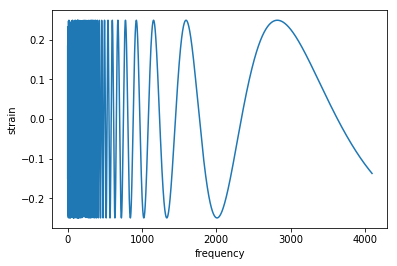

In [31]:
waveform = strain(amplitude, Mass , distance , Neta , frequencies , tc , phic)
plt.figure()
plt.plot(frequencies,waveform)
plt.xlabel('frequency')
plt.ylabel('strain')
plt.show()

#### Below I define the constants I will use in the model as well as the random variable (mass and neta)

In [32]:
with pm.Model() as gw_model:
    neta = pm.Normal('neta' , mu = 0.1 , sd = 0.2)
    mass = pm.Normal('mass' , mu = 25 , sd = 100)
    amplitude = 10**-3
    Mass = 30
    distance = 1
    Neta = 0.25
    tc=0
    phic =0

#### Next define the GW wave model within the pm.Model() framework

In [34]:
with gw_model : 
    phase = 2*np.pi*frequencies*tc + phic + 3/(128 * neta * (np.pi*mass)**(5/3))*frequencies**(-4/3)
    exponent = 1j*phase + 1j*(np.pi/4) 
    strain = (amplitude * mass**(5/6))/(distance*np.pi**(2/3))* ((5*neta)/(24))**(-7/6)*np.exp(exponent)
    diff = np.linalg.norm(waveform - strain)
    likelihood = pm.Normal('obs' , mu = diff
                           , sd =1 , observed = np.random.normal( 0 , 1, len(waveform)))
    

#### compare a log likelihood evaluation between correct and incorrect parameters


In [35]:
right = gw_model.logp({'mass': 30 , 'neta':0.25})
wrong = gw_model.logp({'mass': 100 , 'neta':0.1})
print(right)
print(wrong)

In [37]:
with gw_model : 
    approx = pm.fit(method = 'advi',  n = 50000)
#     trace = pm.sample(2000 , method = '' , tune = 500)
    

AssertionError: 